# VBF to e+ e- codes 

Utilising alot of the same techniques from the Z boson analysis we will now begin to approach vector boson fusion analysis. 

Install and load all packages

In [2]:
pip install uproot 

     -------------------------------------- 342.7/342.7 kB 7.1 MB/s eta 0:00:00
     ------------------------------------- 737.7/737.7 kB 11.7 MB/s eta 0:00:00
     ------------------------------------- 536.8/536.8 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.3
    Uninstalling importlib-metadata-4.11.3:
      Successfully uninstalled importlib-metadata-4.11.3
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install vector 

     -------------------------------------- 171.3/171.3 kB 5.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
import uproot 
import vector 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import awkward as ak 

Define all functions that will extract the data from the root file, filter events that have at least two jets and two electrons, calculate plot variables, and filter the plotting data based on cuts.

In [26]:
def data_extract(rootfilename):
    # Opens the .root file and extracts the data
    
    tree = uproot.open(rootfilename + '.root:Delphes')
    events = tree.arrays(['Event.Weight', 'Electron_size', 'Electron.PT', 'Electron.Eta', 'Electron.Phi',
                          'Jet_size', 'Jet.PT', 'Jet.Eta', 'Jet.Phi', 'Jet.TauTag', 'Jet.Mass', 'Jet.Flavor', 'Jet.BTag'])
    return events

def jets_and_two_electrons(event, b_selection, pt_selection):
    #Selects events with two electrons and at least two jets, that can change the jet filters selection = 0 filter for no b jets and 2 or 3 light, 
    # selection = 1 is no B jets, selection = 2 doesnt mask based on b tagging 
    
    # Creates arrays for electrons and jets with selected events
    electrons = vector.zip({'pt': (event['Electron.PT']), 'eta': (event['Electron.Eta']),
                            'phi': (event['Electron.Phi']), 'mass': 0.0511})
    jets = vector.zip({'pt': (event['Jet.PT']), 'eta': (event['Jet.Eta']),
                       'phi': (event['Jet.Phi']), 'mass': (event['Jet.Mass'])})
    
    
    two_e_mask = event['Electron_size'] == 2
    
    pt_above_25 = event['Jet.PT'] >= 25
    filtered_data_25 = jets[pt_above_25]
    two_jets_above_25_mask = ak.num(filtered_data_25, axis=1) >= 2 
    #requires that we only consider events with at least 2 jets above 25GeV, anything below we dont consider as jets.
    
    b_tag = event['Jet.BTag'] == 1
    filtered_data_b = jets[b_tag]
    no_b_jet_mask = ak.num(filtered_data_b, axis=1) == 0 
    
    light_jets = event['Jet.BTag'] == 0
    filtered_data_light = jets[light_jets]
    n_light_jet_min_mask = ak.num(filtered_data_light, axis=1) >= 2 
    n_light_jet_max_mask = ak.num(filtered_data_light, axis=1) <= 3 
    n_light_jet_mask = n_light_jet_min_mask & n_light_jet_max_mask
    
    
    if b_selection == 0:
        event_mask = two_jets_above_25_mask & two_e_mask & no_b_jet_mask & n_light_jet_min_mask & n_light_jet_max_mask 
    elif b_selection == 1:
        event_mask = two_jets_above_25_mask & two_e_mask & no_b_jet_mask 
    elif b_selection == 2:
        event_mask = two_jets_above_25_mask & two_e_mask 
        
    # Creates arrays for electrons and jets with selected events
    electrons = vector.zip({'pt': (event['Electron.PT']), 'eta': (event['Electron.Eta']),
                            'phi': (event['Electron.Phi']), 'mass': 0.0511})
    jets = vector.zip({'pt': (event['Jet.PT']), 'eta': (event['Jet.Eta']),
                       'phi': (event['Jet.Phi']), 'mass': (event['Jet.Mass'])})

    dielectrons = electrons[event_mask]
    jets_filtered = jets[event_mask] 
    
    jet_above_25_mask = jets_filtered.pt >= 25
    # extra filter that on events that pass selection only include jets above 25 GeV 
    jets_filtered_above_25 = jets_filtered[jet_above_25_mask]
    
    if pt_selection == True: 
        jets_returned = jets_filtered_above_25
    else: 
        jets_returned = jets_filtered

    return dielectrons, jets_returned


def invariant_mass_calculator(dielectrons, jets):
    # Calculates various invariant masses
    
    invariant_mass_array = (dielectrons[:, 0] + dielectrons[:, 1] + jets[:, 0] + jets[:, 1]).mass
    jj_invariant_mass_array = (jets[:, 0] + jets[:, 1]).mass
    ee_invariant_mass_array = (dielectrons[:, 0] + dielectrons[:, 1]).mass

    return [invariant_mass_array, jj_invariant_mass_array, ee_invariant_mass_array]

def transverse_momentum_calculator(dielectrons, jets):
    # Calculates transverse momentum values
    
    pt_array = (dielectrons[:, 0] + dielectrons[:, 1] + jets[:, 0] + jets[:, 1]).pt
    jet_1_pt_array = (jets[:, 0]).pt
    jet_2_pt_array = (jets[:, 1]).pt
    e_1_pt_array = (dielectrons[:, 0]).pt
    e_2_pt_array = (dielectrons[:, 1]).pt

    return [pt_array, jet_1_pt_array, jet_2_pt_array, e_1_pt_array, e_2_pt_array]

def rapidity_calculator(dielectrons, jets):
    # Calculates rapidity-related quantities
    
    eta_array = (dielectrons[:, 0] + dielectrons[:, 1] + jets[:, 0] + jets[:, 1]).rapidity
    eta_separation_array = abs((jets[:, 0]).rapidity - (jets[:, 1]).rapidity)
    centrality_array = (((dielectrons[:, 0] + dielectrons[:, 1]).rapidity - 0.5*((jets[:, 0]).rapidity
                                                    + (jets[:, 1]).rapidity)) / (eta_separation_array))

    return [eta_array, eta_separation_array, centrality_array]

def pt_balance_calculator(dielectrons, jets):
    # Calculates transverse momentum balance
    
    pt_sin = (jets[:, 0].pt * np.sin(jets[:, 0].phi) + jets[:, 1].pt * np.sin(jets[:, 1].phi)
              + dielectrons[:, 0].pt * np.sin(dielectrons[:, 0].phi) + dielectrons[:, 1].pt * np.sin(dielectrons[:, 1].phi))

    pt_cos = (jets[:, 0].pt * np.cos(jets[:, 0].phi) + jets[:, 1].pt * np.cos(jets[:, 1].phi)
              + dielectrons[:, 0].pt * np.cos(dielectrons[:, 0].phi) + dielectrons[:, 1].pt * np.cos(dielectrons[:, 1].phi))

    pt_vector_sum = pow((pow(pt_sin, 2) + pow(pt_cos, 2)), 0.5)

    pt_scalar_sum = (jets[:, 0].pt + jets[:, 1].pt + dielectrons[:, 0].pt + dielectrons[:, 1].pt)

    pt_balance = pt_vector_sum / pt_scalar_sum

    return pt_balance

def n_gap_jets(jets):
    # Calculates the number of jets in the rapidity gap
    
    eta_1 = jets[:, 0].eta
    eta_2 = jets[:, 1].eta
    eta_min = ak.where(eta_1 < eta_2, eta_1, eta_2)
    eta_max = ak.where(eta_1 < eta_2, eta_2, eta_1)
    mask = (jets.eta >= eta_min) & (jets.eta <= eta_max)
    filtered_data = jets[mask]
    n_gap = ak.num(filtered_data, axis=1) - 2

    return n_gap


def hist_plotter(data, cut_bool, cuts, min_, max_est, bin_number, imagename, title, xlabel, log, error):
    # Plots histograms
    
    plt.title(title)

    handles = []
    labels = []

    if cut_bool == True:
        bin_width_est = (max_est - min_) / bin_number
        num = round((cuts[0] - min_) / bin_width_est)
        bin_width = (cuts[0] - min_) / num
        max_ = min_ + bin_width * bin_number
        hist, edges, _ = plt.hist(data, bins=bin_number, range=(min_, max_), alpha=0.8, label=f'Data (N={len(data)})')
        handles.append(mpatches.Rectangle((0, 0), 1, 1))
        labels.append(f'Data (N={len(data)})')

        for element in cuts:
            plt.axvline(element, color='red', linestyle='--', linewidth=1.5, alpha=1)
            handles.append(plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1.5, alpha=1))
            labels.append(f'Cut value: {element}')
    else:
        max_ = max_est
        hist, edges, _ = plt.hist(data, bins=bin_number, range=(min_, max_), alpha=0.8, label=f'Data (N={len(data)})')
        bin_width = ((max_ - min_)/bin_number)
        handles.append(mpatches.Rectangle((0, 0), 1, 1))
        labels.append(f'Data (N={len(data)})')
        
    if error == True:    
        centres = edges + bin_width*0.5
        centres = centres[:-1]
        remove = np.where(hist==0)
        errors = np.sqrt(hist)
        errors = np.delete(errors, remove)
        hist = np.delete(hist, remove)
        centres = np.delete(centres, remove)
        if log == True: 
            errors = errors/hist 
        plt.errorbar(centres, hist, yerr = errors, color='black', fmt = '.', alpha=0.3, capsize = 1)
        
    plt.xlabel(xlabel)
    plt.legend(handles, labels, loc='upper right')
    if log == True:
        plt.yscale('log')
        plt.ylabel('Log(Events)')
    elif log == False:
        plt.ylabel('Events')
    plt.savefig(imagename + ".png")

    plt.show()

    
def non_leading_jet_pt_calculator(jets, mask): 
    
    pt_array = jets.pt
    
    non_leading_pt = pt_array[:,2:]
    print(non_leading_pt)
    non_leading_pt_filt = non_leading_pt[mask]
    non_leading_pt_array = np.array([])
    non_leading_filt_pt_array = np.array([])
    for element in non_leading_pt:
        non_leading_pt_array = np.append(non_leading_pt_array, element)
    for element in non_leading_pt_filt:
        non_leading_filt_pt_array = np.append(non_leading_filt_pt_array, element)
   
    return non_leading_pt_array, non_leading_filt_pt_array


def plot_data_structure(events, b_selection, pt_selection):
    # Constructs an array for plotting from events data
    
    dielectrons, jets = jets_and_two_electrons(events, b_selection, pt_selection)
        
    m_tot, m_jj, m_ee = invariant_mass_calculator(dielectrons, jets)
    eta, eta_sep, centrality = rapidity_calculator(dielectrons, jets)
    pt_balance = pt_balance_calculator(dielectrons, jets)
    pt, jet_1_pt, jet_2_pt, e_1_pt, e_2_pt = transverse_momentum_calculator(dielectrons, jets)
    n_gap = n_gap_jets(jets)

    m_tot_vert = np.reshape(m_tot, (len(m_tot), 1))
    m_jj_vert = np.reshape(m_jj, (len(m_jj), 1))
    m_ee_vert = np.reshape(m_ee, (len(m_ee), 1))
    eta_vert = np.reshape(eta, (len(eta), 1))
    eta_sep_vert = np.reshape(eta_sep, (len(eta_sep), 1))
    centrality_vert = np.reshape(centrality, (len(centrality), 1))
    pt_balance_vert = np.reshape(pt_balance, (len(pt_balance), 1))
    pt_vert = np.reshape(pt, (len(pt), 1))
    jet_1_pt_vert = np.reshape(jet_1_pt, (len(jet_1_pt), 1))
    jet_2_pt_vert = np.reshape(jet_2_pt, (len(jet_2_pt), 1))
    e_1_pt_vert = np.reshape(e_1_pt, (len(e_1_pt), 1))
    e_2_pt_vert = np.reshape(e_2_pt, (len(e_2_pt), 1))
    n_gap_vert = np.reshape(n_gap, (len(n_gap), 1))

    arr_1 = np.hstack((m_tot_vert, m_jj_vert))
    arr_2 = np.hstack((arr_1, m_ee_vert))
    arr_3 = np.hstack((arr_2, eta_vert))
    arr_4 = np.hstack((arr_3, eta_sep_vert))
    arr_5 = np.hstack((arr_4, centrality_vert))
    arr_6 = np.hstack((arr_5, pt_balance_vert))
    arr_7 = np.hstack((arr_6, pt_vert))
    arr_8 = np.hstack((arr_7, jet_1_pt_vert))
    arr_9 = np.hstack((arr_8, jet_2_pt_vert))
    arr_10 = np.hstack((arr_9, e_1_pt_vert))
    arr_11 = np.hstack((arr_10, e_2_pt_vert))
    plot_data_array = np.hstack((arr_11, n_gap_vert))

    # array structure: (m_tot, m_jj, m_ee, eta, eta_sep, centrality, pt_balance, pt_vert, jet_1_pt, jet_2_pt, e_1_pt, e_2_pt)

    return plot_data_array

def masks(plot_data_array, cut_values, gap_bool):
    # Applies masks to the plot_data_array based on specified criteria
    # cut_values structure: [m_tot, m_jj, m_ee_min, m_ee_max, eta, eta_sep, centrality, pt_balance, pt, pt_j1, pt_j2, pt_e1, pt_e2]

    m_tot_mask = plot_data_array[:, 0] >= cut_values[0]
    m_jj_mask = plot_data_array[:, 1] >= cut_values[1]
    m_ee_min_mask = plot_data_array[:, 2] >= cut_values[2]
    m_ee_max_mask = plot_data_array[:, 2] <= cut_values[3]
    eta_mask = abs(plot_data_array[:, 3]) >= cut_values[4]
    eta_sep_mask = plot_data_array[:, 4] >= cut_values[5]
    centrality_min_mask = abs(plot_data_array[:, 5]) >= cut_values[6]
    centrality_max_mask = abs(plot_data_array[:, 5]) <= cut_values[7]
    pt_balance_mask = plot_data_array[:, 6] <= cut_values[8]
    pt_vert_mask = plot_data_array[:, 7] >= cut_values[9]
    jet_1_pt_mask = plot_data_array[:, 8] >= cut_values[10]
    jet_2_pt_mask = plot_data_array[:, 9] >= cut_values[11]
    e_1_pt_mask = plot_data_array[:, 10] >= cut_values[12]
    e_2_pt_mask = plot_data_array[:, 11] >= cut_values[13]
    n_gap_mask = plot_data_array[:,12] == cut_values[14]
    #cannot exclude n gap filter by setting to zero or infinity as ==
    if gap_bool == True:
        mask = m_tot_mask & m_jj_mask & m_ee_min_mask & m_ee_max_mask & eta_mask & eta_sep_mask & centrality_min_mask & centrality_max_mask & pt_balance_mask & pt_vert_mask & jet_1_pt_mask & jet_2_pt_mask & e_1_pt_mask & e_2_pt_mask & n_gap_mask
    else:
        mask = m_tot_mask & m_jj_mask & m_ee_min_mask & m_ee_max_mask & eta_mask & eta_sep_mask & centrality_min_mask & centrality_max_mask & pt_balance_mask & pt_vert_mask & jet_1_pt_mask & jet_2_pt_mask & e_1_pt_mask & e_2_pt_mask 

    cut_plot_data = plot_data_array[mask]

    return cut_plot_data, mask

The output of all these routines is the cut_plot_data. Note in order to have no cuts and view unfiltered data just set all values to zero in the masks. 

Plot array structure: (m_tot, m_jj, m_ee, eta, eta_sep, centrality, pt_balance, pt_vert, jet_1_pt, jet_2_pt, e_1_pt, e_2_pt)

Below we can run all the the files, outputting the data and plots, then saving all under appropriate names.

hist_plotter(data, cut_bool, cuts, min_, max_, bin_number, imagename, title, xlabel, log)

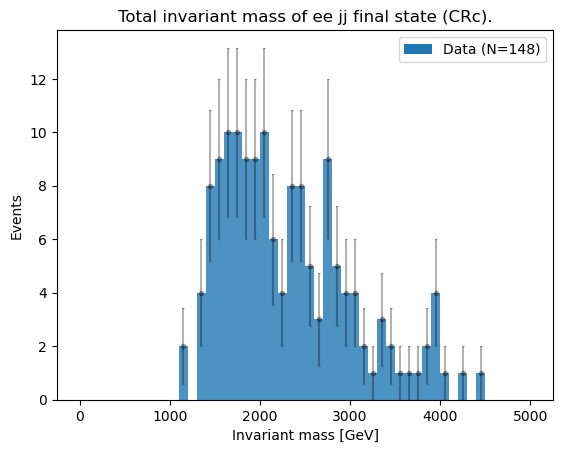

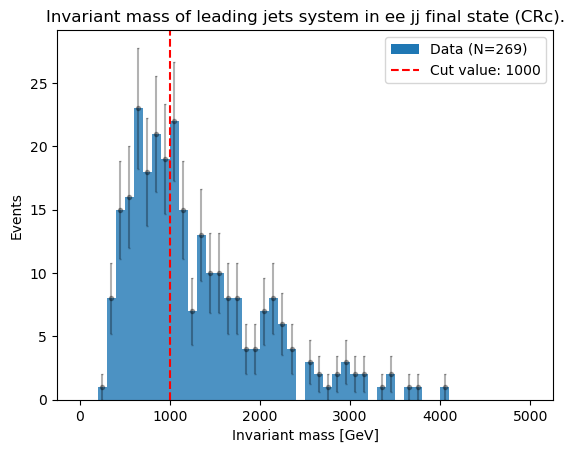

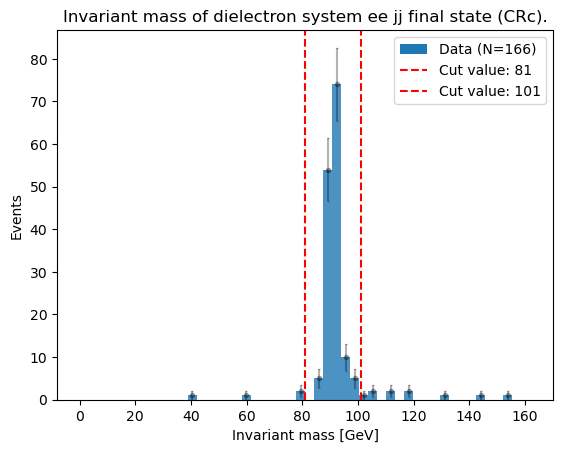

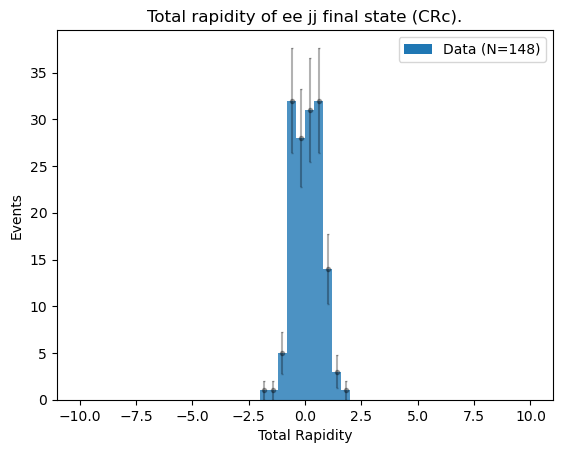

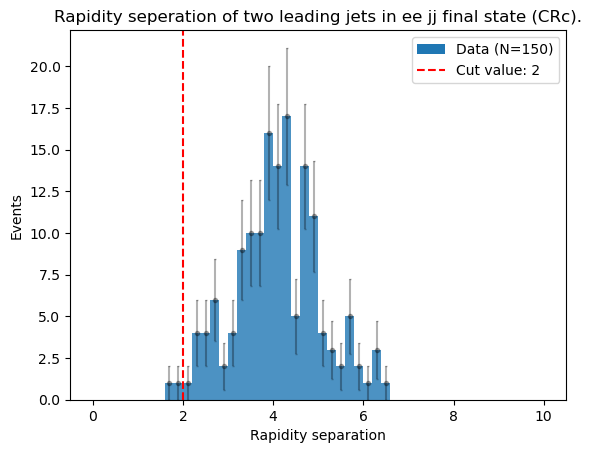

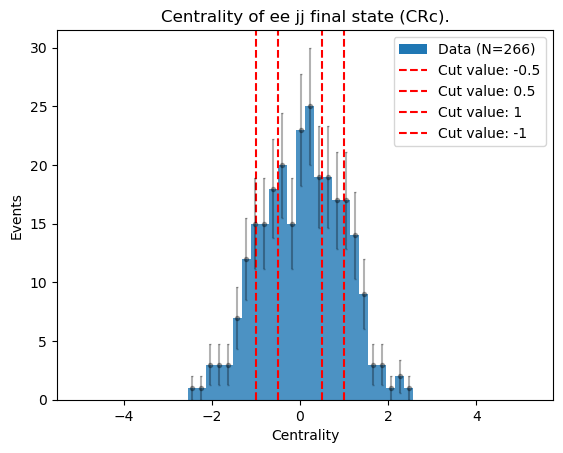

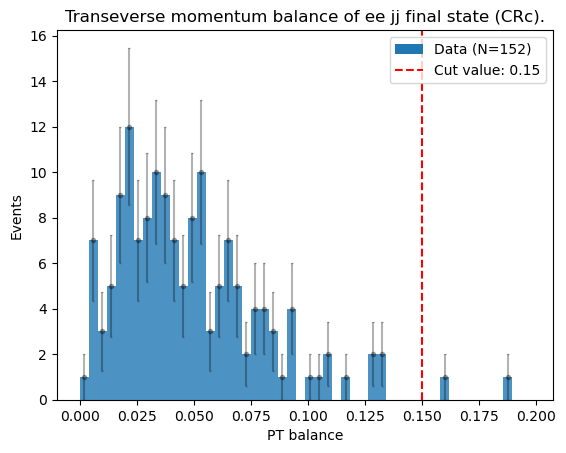

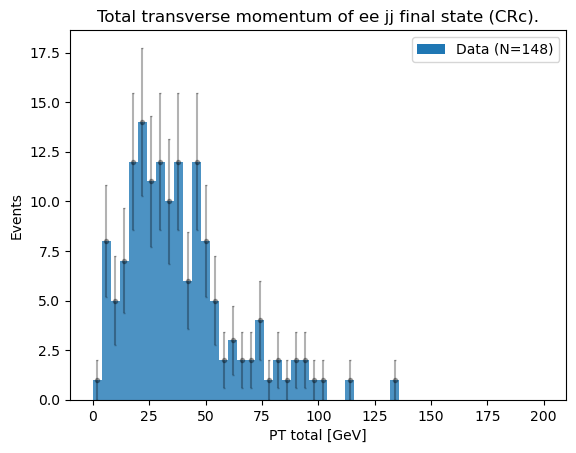

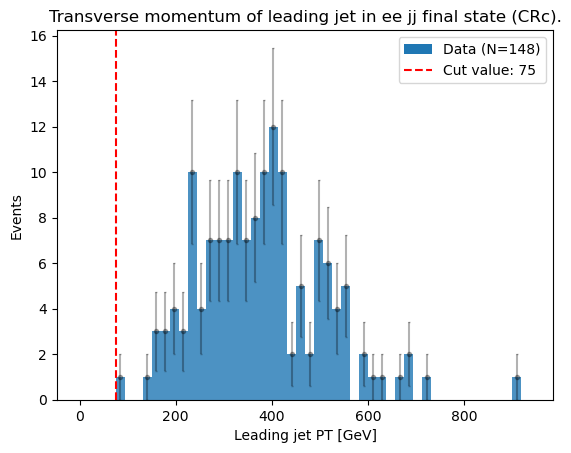

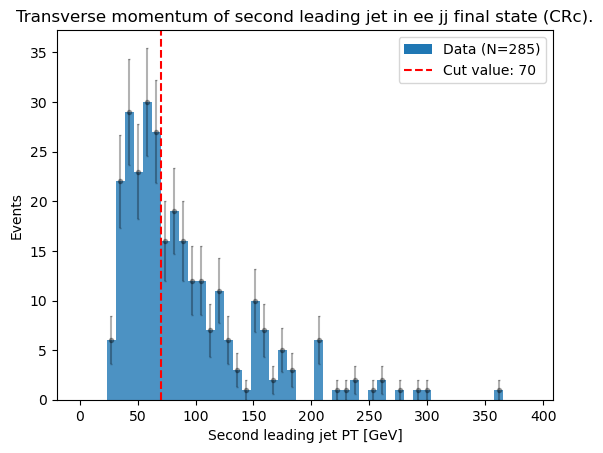

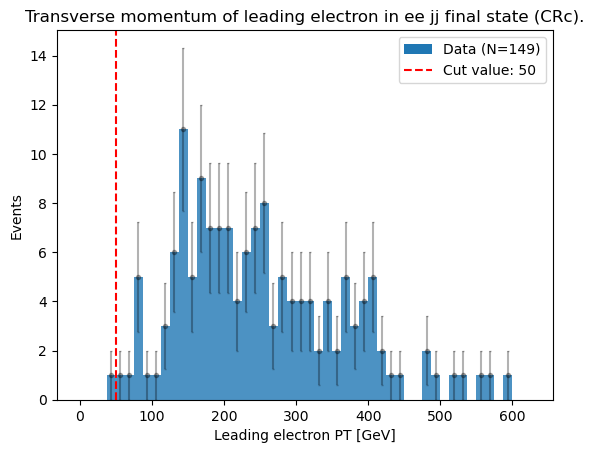

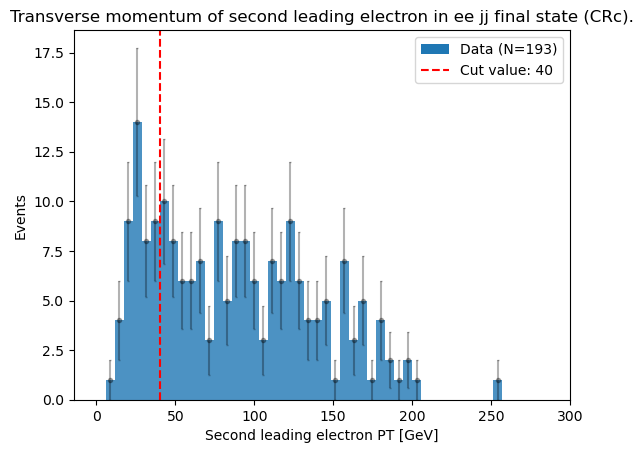

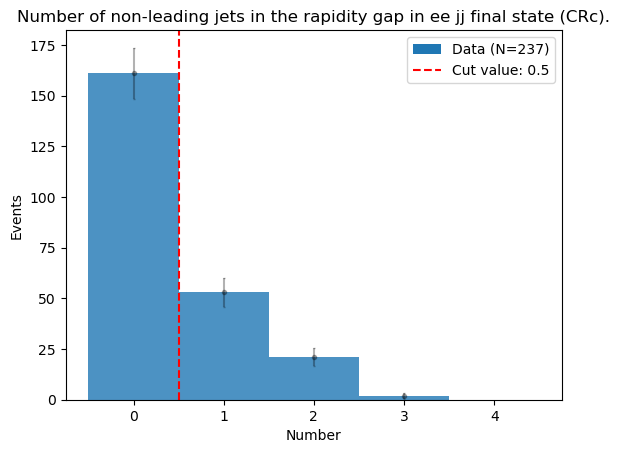

[[57.4, 43.1], [45.4], [], [150, 112, ..., 23.1], ..., [], [], [], [159, 26.1]]


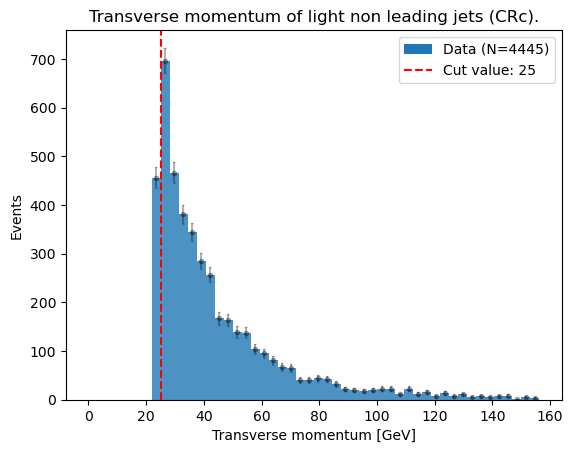

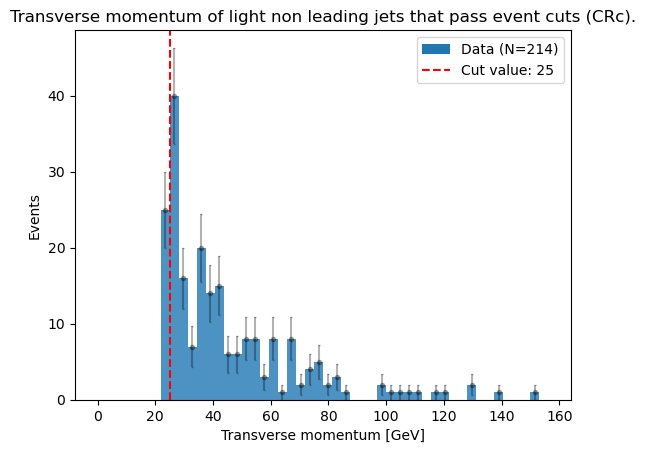

[[57.4, 43.1], [45.4], [], [150, 112, ..., 23.1], ..., [], [], [], [159, 26.1]]


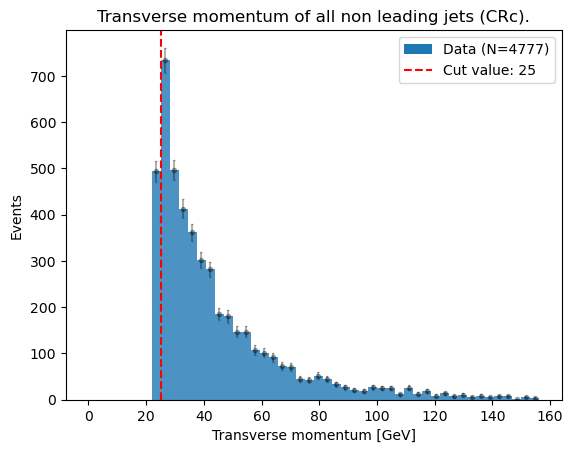

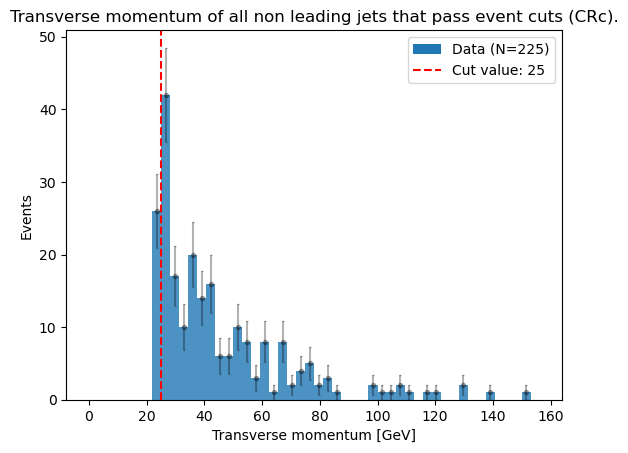

In [37]:
# Extract data from the .root file and create a structured array for plotting
plot_data = plot_data_structure(data_extract('delphes_vbf_6_output'), 0, True)
plot_data_no_light_jet_cut = plot_data_structure(data_extract('delphes_vbf_6_output'), 1, True)

# Define cut values for various variables
# cut_values structure: [m_tot, m_jj, m_ee_min, m_ee_max, eta, eta_sep, centrality_min, centrality_max, pt_balance, pt, pt_j1, pt_j2, pt_e1, pt_e2]

centrality_min = 0.5
centrality_max = 1.5
n_gap = 0
region_name = 'CRc'
region_title = '(CRc).'

cut_values = [0, 1000, 81, 101, 0, 2, centrality_min, centrality_max, 0.15, 0, 75, 70, 50, 40, n_gap]
cut_values_no_jj_im = [0, 0, 81, 101, 0, 2, centrality_min, centrality_max, 0.15, 0, 75, 70, 50, 40, n_gap]
cut_values_no_ee_im = [0, 1000, 0, np.inf, 0, 2, centrality_min, centrality_max, 0.15, 0, 75, 70, 50, 40, n_gap]
cut_values_no_eta_sep = [0, 1000, 81, 101, 0, 0, centrality_min, centrality_max, 0.15, 0, 75, 70, 50, 40, n_gap]
cut_values_no_pt_bal = [0, 1000, 81, 101, 0, 2, centrality_min, centrality_max, np.inf, 0, 75, 70, 50, 40, n_gap]
cut_values_no_j1_pt = [0, 1000, 81, 101, 0, 2, centrality_min, centrality_max, 0.15, 0, 0, 70, 50, 40, n_gap]
cut_values_no_j2_pt = [0, 1000, 81, 101, 0, 2, centrality_min, centrality_max, 0.15, 0, 75, 0, 50, 40, n_gap]
cut_values_no_e1_pt = [0, 1000, 81, 101, 0, 2, centrality_min, centrality_max, 0.15, 0, 75, 70, 0, 40, n_gap]
cut_values_no_e2_pt = [0, 1000, 81, 101, 0, 2, centrality_min, centrality_max, 0.15, 0, 75, 70, 50, 0, n_gap]
cut_values_no_cent = [0, 1000, 81, 101, 0, 2, 0, np.inf, 0.15, 0, 75, 70, 50, 40, n_gap]

# Apply different cuts to the plot data
cut_data, null = masks(plot_data, cut_values, True)
cut_data_no_jj_im, null = masks(plot_data, cut_values_no_jj_im, True)
cut_data_no_ee_im, null = masks(plot_data, cut_values_no_ee_im, True)
cut_data_no_eta_sep, null = masks(plot_data, cut_values_no_eta_sep, True)
cut_data_no_pt_bal, null = masks(plot_data, cut_values_no_pt_bal, True)
cut_data_no_j1_pt, null = masks(plot_data, cut_values_no_j1_pt, True)
cut_data_no_j2_pt, null = masks(plot_data, cut_values_no_j2_pt, True)
cut_data_no_e1_pt, null = masks(plot_data, cut_values_no_e1_pt, True)
cut_data_no_e2_pt, null = masks(plot_data, cut_values_no_e2_pt, True)
cut_data_no_e2_pt, null = masks(plot_data, cut_values_no_e2_pt, True)
cut_data_no_cent, null = masks(plot_data, cut_values_no_cent, True)
cut_data_no_n_gap, null = masks(plot_data_no_light_jet_cut, cut_values, False)

# Plot histograms based on the cut data
hist_plotter(cut_data[:,0],False, [0], 0, 5000, 50, 'vbf_6_plots_cut_tot_im_'+region_name, 'Total invariant mass of ee jj final state '+region_title, 'Invariant mass [GeV]', False, True)
hist_plotter(cut_data_no_jj_im[:,1], True, [1000], 0, 5000, 50, 'vbf_6_plots_cut_jj_im_'+region_name, 'Invariant mass of leading jets system in ee jj final state '+region_title, 'Invariant mass [GeV]', False, True)
hist_plotter(cut_data_no_ee_im[:,2], True, [81,101], 0, 160, 50, 'vbf_6_plots_cut_ee_im_'+region_name, 'Invariant mass of dielectron system ee jj final state '+region_title, 'Invariant mass [GeV]', False, True)
hist_plotter(cut_data[:,3], False, [0], -10, 10, 50, 'vbf_6_plots_cut_eta_'+region_name, 'Total rapidity of ee jj final state '+region_title, 'Total Rapidity', False, True)
hist_plotter(cut_data_no_eta_sep[:,4], True, [2], 0, 10, 50, 'vbf_6_plots_cut_eta_sep_'+region_name, 'Rapidity seperation of two leading jets in ee jj final state '+region_title, 'Rapidity separation', False, True)
hist_plotter(cut_data_no_cent[:,5], True,[-0.5,0.5, 1, -1], -5, 5, 50, 'vbf_6_plots_cut_centrality_'+region_name, 'Centrality of ee jj final state '+region_title, 'Centrality', False, True)
hist_plotter(cut_data_no_pt_bal[:,6], True, [0.15], 0, 0.2, 50, 'vbf_6_plots_cut_pt_balance_'+region_name, 'Transeverse momentum balance of ee jj final state '+region_title, 'PT balance', False, True)
hist_plotter(cut_data[:,7], False, [0], 0, 200, 50, 'vbf_6_plots_cut_pt_'+region_name, 'Total transverse momentum of ee jj final state '+region_title, 'PT total [GeV]', False, True)
hist_plotter(cut_data_no_j1_pt[:,8], True, [75], 0, 1000, 50, 'vbf_6_plots_cut_j1_pt_'+region_name, 'Transverse momentum of leading jet in ee jj final state '+region_title, 'Leading jet PT [GeV]', False, True)
hist_plotter(cut_data_no_j2_pt[:,9], True, [70], 0, 400, 50, 'vbf_6_plots_cut_j2_pt_'+region_name, 'Transverse momentum of second leading jet in ee jj final state '+region_title, 'Second leading jet PT [GeV]',False, True)
hist_plotter(cut_data_no_e1_pt[:,10], True, [50], 0, 600, 50, 'vbf_6_plots_cut_e1_pt_'+region_name, 'Transverse momentum of leading electron in ee jj final state '+region_title, 'Leading electron PT [GeV]',False, True)
hist_plotter(cut_data_no_e2_pt[:,11], True, [40], 0, 300, 50, 'vbf_6_plots_cut_e2_pt_'+region_name, 'Transverse momentum of second leading electron in ee jj final state '+region_title, 'Second leading electron PT [GeV]',False, True)
hist_plotter(cut_data_no_n_gap[:,12], True, [0.5], -0.5, 4.5, 5, 'vbf_6_plots_n_gap_no_light_jet_cut_'+region_name, 'Number of non-leading jets in the rapidity gap in ee jj final state '+region_title, 'Number',False, True)


# plots the transverse momenta of non-leading jets, have to relax the restriction of 2-3 light jets otherwise we just cut out loads of non-leading jest
dielectrons, jets = jets_and_two_electrons(data_extract('delphes_vbf_6_output'),1, False)
plot_data = plot_data_structure(data_extract('delphes_vbf_6_output'), 1, False)# used to create new mask with the relaxations
null_data, mask = masks(plot_data, cut_values, False)
non_leading_pt_array, non_leading_filt_pt_array = non_leading_jet_pt_calculator(jets, mask)
hist_plotter(non_leading_pt_array, True, [25], 0, 150, 50, 'vbf_6_plots_non_leading_pt_'+region_name, 'Transverse momentum of light non leading jets '+region_title, 'Transverse momentum [GeV]', False, True)
hist_plotter(non_leading_filt_pt_array, True, [25], 0, 150, 50, 'vbf_6_plots_non_leading_pt_event_filter_'+region_name, 'Transverse momentum of light non leading jets that pass event cuts '+region_title, 'Transverse momentum [GeV]', False, True)


# plots the transverse momenta of the non- leading jets, with the n light jet restriction relaxed and now also relax restriction on there being no events that include a b tagged jet
dielectrons, jets = jets_and_two_electrons(data_extract('delphes_vbf_6_output'),2, False)
plot_data = plot_data_structure(data_extract('delphes_vbf_6_output'), 2, False) # used to create new mask with the relaxations
null_data, mask = masks(plot_data, cut_values, False)
non_leading_pt_array, non_leading_filt_pt_array = non_leading_jet_pt_calculator(jets, mask)
hist_plotter(non_leading_pt_array, True, [25], 0, 150, 50, 'vbf_6_plots_non_leading_pt_with_b_'+region_name, 'Transverse momentum of all non leading jets '+region_title, 'Transverse momentum [GeV]', False, True)
hist_plotter(non_leading_filt_pt_array, True, [25], 0, 150, 50, 'vbf_6_plots_non_leading_pt_event_filter_with_b_'+region_name, 'Transverse momentum of all non leading jets that pass event cuts '+region_title, 'Transverse momentum [GeV]', False, True)

hist_plotter(data, cut_bool, cuts, min_, max_est, bin_number, imagename, title, xlabel, log, error):hist_plotter(data, cut_bool, cuts, min_, max_est, bin_number, imagename, title, xlabel, log, error):

In [42]:
def b_tagging_info(event):
    two_e_mask = event['Electron_size'] == 2
    two_jet_mask = event['Jet_size'] >= 2
    b_tag_array = event['Jet.BTag'] == 1
    mask = two_e_mask & two_jet_mask
    #b_tag_events = event[mask]
    jets = vector.zip({'pt': (event['Jet.PT']), 'eta': (event['Jet.Eta']),
                       'phi': (event['Jet.Phi']), 'mass': (event['Jet.Mass'])})
   
    b_tag_jets = jets[mask & b_tag_array]
    b_tagged_pt= b_tag_jets.pt
    b_tagged_pt_array = np.array([])
    for element in (b_tagged_pt):
        b_tagged_pt_array = np.append(b_tagged_pt_array, element)
    b_tagged_flavour_array= np.array([])
   
    flavour = event['Jet.Flavor'][mask]
    flavour_array = np.array([])
    for element in (flavour):
        flavour_array = np.append(flavour_array, element)
   
    b_tagged_flavour = event['Jet.Flavor'][mask & b_tag_array]
    for element in (b_tagged_flavour):
        b_tagged_flavour_array = np.append(b_tagged_flavour_array, element)
       
    b_tag_and_flavor = event['Jet.Flavor'] == 5
    mask2 = mask & b_tag_and_flavor
    b_tagged_pt_flavour = jets[mask2 & b_tag_array].pt
    b_tagged_pt_array_flavour = np.array([])
    for element in (b_tagged_pt_flavour):
        b_tagged_pt_array_flavour = np.append(b_tagged_pt_array_flavour, element)
       
    charm, bottom = flavour_histogram(flavour_array, 23 , -0.5, 23.5,'Flavour of b tagged jets', True, 'flavour_array_of_jets.png')
    charm2, bottom2 = flavour_histogram(b_tagged_flavour_array, 23 , -0.5, 23.5,'Flavour of b tagged jets', True, 'flavour_array_of_b_tagged_jets.png')
    charm_err = np.sqrt((np.sqrt(charm2)/charm2)**2 + (np.sqrt(charm)/charm)**2)*(charm2/charm)
    bottom_err = np.sqrt((np.sqrt(bottom2)/bottom2)**2 + (np.sqrt(bottom)/bottom)**2)*(bottom2/bottom)
    print('The fraction of charm and bottom quarks tagged as b-quarks: ',charm2/charm,' pm ', charm_err, bottom2/bottom,' pm ', bottom_err)
       
def flavour_histogram(data, bin_number, min_, max_, title, error, filename):
    plt.title(title)

    handles = []
    labels = []
   
    hist, edges, _ = plt.hist(data, bins=bin_number, range=(min_, max_), alpha=0.8, label=f'Data (N={len(data)})')
    handles.append(mpatches.Rectangle((0, 0), 1, 1))
    labels.append(f'Data (N={len(data)})')
    bin_width = ((max_ - min_)/bin_number)

    if error == True:    
        centres = edges + bin_width*0.5
        centres = centres[:-1]
        remove = np.where(hist==0)
        errors = np.sqrt(hist)
        errors = np.delete(errors, remove)
        hist = np.delete(hist, remove)
        centres = np.delete(centres, remove)
        plt.errorbar(centres, hist, yerr = errors, color='black', fmt = '.', alpha=0.3, capsize = 1)
    print(hist)    
    plt.xlabel('Flavour bin')
    plt.legend(handles, labels, loc='upper right')
    plt.savefig(filename)
    plt.show()
    return(hist[4], hist[5])

[3731. 2762. 3348. 1840. 1310.  107. 1953.]


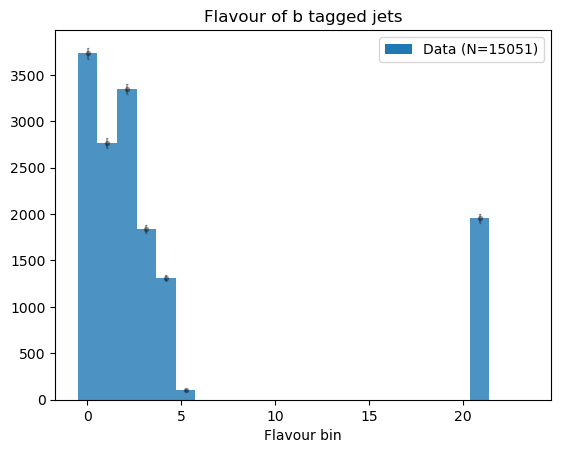

[  9.  13.   8.  11. 150.  65.   8.]


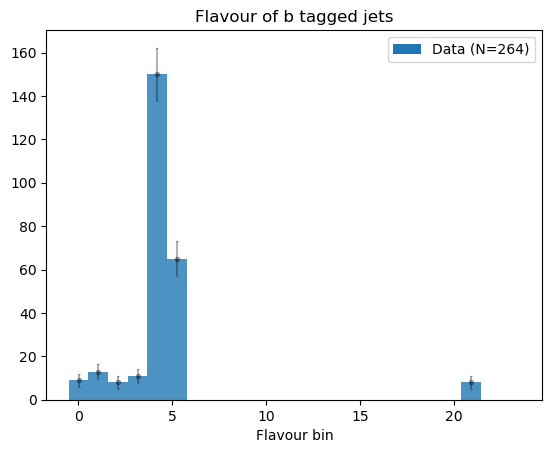

The fraction of charm and bottom quarks tagged as b-quarks:  0.11450381679389313  pm  0.009869953666807825 0.6074766355140186  pm  0.09553120047209564


In [43]:
b_tagging_info(data_extract('delphes_vbf_6_output'))